<a href="https://colab.research.google.com/github/JenBanks8585/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/Jen__Banks_LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [0]:
# Drop column easement as it has no entry at all
df=df.drop(['EASE-MENT'], axis= 1)

In [45]:
#data inspection

print(df.shape)
df.head(5)

(23040, 20)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [46]:
#Checking data types
df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [47]:
df.isnull().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64



---


### Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.

In [48]:
# Grabbing subset that satisfies condition

subset_df= df[(df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS') & (df['SALE_PRICE']>100000) & (df['SALE_PRICE']<2000000)]
print(subset_df.shape)
subset_df.head(2)

(3151, 20)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019




---


### Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [49]:
# Inspecting 'SALE_DATE'
subset_df['SALE_DATE'].value_counts()

01/31/2019    78
03/29/2019    62
02/28/2019    58
01/15/2019    57
01/24/2019    56
              ..
04/14/2019     1
03/30/2019     1
03/17/2019     1
02/17/2019     1
03/09/2019     1
Name: SALE_DATE, Length: 91, dtype: int64

In [50]:
# Splitting the data set into training and testing set

subset_df['SALE_DATE']=pd.to_datetime(subset_df['SALE_DATE'], infer_datetime_format=True)    # Converting str to datetime
cutoff=pd.to_datetime('2019-04-01')                                                          # setting cutoff date
train=subset_df[subset_df.SALE_DATE<cutoff]
test=subset_df[subset_df.SALE_DATE>=cutoff]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
#Checking shape
train.shape, test.shape

((2507, 20), (644, 20))

In [52]:
# Checking descriptive stats for numerical features
train.describe().T

,count,mean,std,min,25%,50%,75%,max
BLOCK,2507.0,6758.303949,3975.909029,21.0,3837.5,6022.0,9888.5,16350.0
LOT,2507.0,75.778221,157.531138,1.0,21.0,42.0,70.0,2720.0
ZIP_CODE,2507.0,10993.398484,494.291462,10301.0,10314.0,11234.0,11413.0,11697.0
RESIDENTIAL_UNITS,2507.0,0.987635,0.110532,0.0,1.0,1.0,1.0,1.0
COMMERCIAL_UNITS,2507.0,0.016354,0.129966,0.0,0.0,0.0,0.0,2.0
TOTAL_UNITS,2507.0,1.003989,0.171794,0.0,1.0,1.0,1.0,3.0
GROSS_SQUARE_FEET,2507.0,1473.744715,599.217635,0.0,1144.0,1368.0,1683.0,7875.0
YEAR_BUILT,2507.0,1944.766653,27.059337,1890.0,1925.0,1940.0,1960.0,2018.0
TAX_CLASS_AT_TIME_OF_SALE,2507.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
SALE_PRICE,2507.0,621573.742321,291607.225676,104000.0,440500.0,560000.0,750000.0,1955000.0


In [53]:
# Checking descriptive stats for categorical features
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaT,NaT
APARTMENT_NUMBER,1,1,RP.,1,NaT,NaT
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaT,NaT
BOROUGH,2507,5,4,1204,NaT,NaT
NEIGHBORHOOD,2507,6,OTHER,2382,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaT,NaT
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30
LAND_SQUARE_FEET,2507,887,"4,000",234,NaT,NaT
ADDRESS,2507,2497,22-40 93RD STREET,2,NaT,NaT


In [54]:
# Inspecting the unique values of 'BOROUGH'
train['BOROUGH'].value_counts()

4    1204
5     662
3     398
2     242
1       1
Name: BOROUGH, dtype: int64

In [55]:
# Grouping by borough the mean sale prices
train.groupby('BOROUGH')['SALE_PRICE'].mean()

BOROUGH
1    739000.000000
2    473104.623967
3    768734.633166
4    649005.172757
5    537305.802115
Name: SALE_PRICE, dtype: float64

In [56]:
# Grouping by borough the descriptive stats of the sale prices
train.groupby('BOROUGH')['SALE_PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
BOROUGH,,,,,,,,
1,1.0,739000.000000,NaN,739000.0,739000.0,739000.0,739000.0,739000.0
2,242.0,473104.623967,184647.130460,108000.0,355000.0,465000.0,550000.0,1750000.0
3,398.0,768734.633166,366138.391194,115000.0,523125.0,676421.5,930000.0,1955000.0
4,1204.0,649005.172757,289512.945057,104000.0,450000.0,601500.0,815000.0,1876000.0
5,662.0,537305.802115,217441.137801,113348.0,415000.0,520000.0,617250.0,1850000.0




---


###Do one-hot encoding of categorical features.

In [0]:
# Defining target and features, removing high cardinality features
target= 'SALE_PRICE'
high_cardinality=['ADDRESS', 
                  'LAND_SQUARE_FEET',
                  'BUILDING_CLASS_AT_PRESENT', 
                  'SALE_DATE']
features=train.columns.drop([target] + high_cardinality)

In [0]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [59]:
X_test.shape, X_train.shape

((644, 15), (2507, 15))

In [60]:
#Checking X_train before one-hot encoding
print(X_train.shape)
X_train.tail(3)

(2507, 15)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE
18132,5,OTHER,01 ONE FAMILY DWELLINGS,1,1132,42,NaN,10302.0,1.0,0.0,1.0,1807.0,2018.0,1,A1
18134,5,OTHER,01 ONE FAMILY DWELLINGS,1,3395,37,NaN,10305.0,1.0,0.0,1.0,621.0,1930.0,1,A2
18147,4,OTHER,01 ONE FAMILY DWELLINGS,1,11159,11,NaN,11429.0,1.0,0.0,1.0,1163.0,1950.0,1,A0


In [61]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encode= encoder.fit_transform(X_train)
X_test_encode= encoder.transform(X_test)

print(X_train.shape)
print(X_test.shape)
#X_train.head(2)

(2507, 15)
(644, 15)


In [62]:
X_train[X_train['TOTAL_UNITS']==3]

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE
7115,3,OTHER,01 ONE FAMILY DWELLINGS,1,5050,2,NaN,11225.0,1.0,2.0,3.0,2128.0,1905.0,1,S0




---


###Do feature selection with SelectKBest.

In [0]:
def engineer_features(X):
    
    # Avoid SettingWithCopyWarning
    X = X.copy()
    
    
    # Are cats or dogs allowed?
    X['TOTAL_UNITS'] = (X['RESIDENTIAL_UNITS']) + (X['COMMERCIAL_UNITS'])

    return X

X_train_eng = engineer_features(X_train_encode)
X_test_eng = engineer_features(X_test_encode)

In [64]:
X_train_eng.dtypes


BOROUGH_3                                            int64
BOROUGH_4                                            int64
BOROUGH_2                                            int64
BOROUGH_5                                            int64
BOROUGH_1                                            int64
NEIGHBORHOOD_OTHER                                   int64
NEIGHBORHOOD_FLUSHING-NORTH                          int64
NEIGHBORHOOD_BEDFORD STUYVESANT                      int64
NEIGHBORHOOD_FOREST HILLS                            int64
NEIGHBORHOOD_BOROUGH PARK                            int64
NEIGHBORHOOD_ASTORIA                                 int64
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS      int64
TAX_CLASS_AT_PRESENT_1                               int64
TAX_CLASS_AT_PRESENT_1D                              int64
BLOCK                                                int64
LOT                                                  int64
APARTMENT_NUMBER_nan                                 int

In [0]:
# Imports
from sklearn.feature_selection import SelectKBest, f_regression

In [66]:
# Instantiating 

selector=SelectKBest(score_func=f_regression, k = 10)

# Fitting/transform

X_train_kbest = selector.fit_transform(X_train_eng, y_train)
X_test_kbest = selector.transform(X_test_eng)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [67]:
# Checking shapes

X_train_kbest.shape,X_test_kbest.shape

((2507, 10), (644, 10))

In [68]:
# defining mask that satisfies the top 10 chosen features
mask=selector.get_support()
mask

array([ True, False,  True,  True, False,  True,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False])

In [69]:
# Selected features

X_train_eng.columns[mask]

Index(['BOROUGH_3', 'BOROUGH_2', 'BOROUGH_5', 'NEIGHBORHOOD_OTHER',
       'NEIGHBORHOOD_FLUSHING-NORTH', 'NEIGHBORHOOD_FOREST HILLS', 'ZIP_CODE',
       'TOTAL_UNITS', 'GROSS_SQUARE_FEET',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A3'],
      dtype='object')

In [70]:
# Featires NOT selected( not in top 10)
X_train_eng.columns[~mask]

Index(['BOROUGH_4', 'BOROUGH_1', 'NEIGHBORHOOD_BEDFORD STUYVESANT',
       'NEIGHBORHOOD_BOROUGH PARK', 'NEIGHBORHOOD_ASTORIA',
       'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
       'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'BLOCK', 'LOT',
       'APARTMENT_NUMBER_nan', 'APARTMENT_NUMBER_RP.', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A9',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A1',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A0',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A2',
       'BUILDING_CLASS_AT_TIME_OF_SALE_S1',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A4',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A6',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A8',
       'BUILDING_CLASS_AT_TIME_OF_SALE_S0'],
      dtype='object')

In [71]:
X_test_eng

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,APARTMENT_NUMBER_nan,APARTMENT_NUMBER_RP.,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
18235,0,0,1,0,0,1,0,0,0,0,0,1,1,0,5913,878,1,0,10471.0,1.0,0.0,1.0,2272.0,1930.0,1,0,1,0,0,0,0,0,0,0,0,0
18239,0,0,1,0,0,1,0,0,0,0,0,1,1,0,5488,48,1,0,10465.0,1.0,0.0,1.0,720.0,1935.0,1,0,0,0,0,1,0,0,0,0,0,0
18244,1,0,0,0,0,1,0,0,0,0,0,1,1,0,5936,31,1,0,11209.0,1.0,0.0,1.0,2210.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
18280,1,0,0,0,0,1,0,0,0,0,0,1,1,0,7813,24,1,0,11210.0,1.0,0.0,1.0,1520.0,1915.0,1,0,0,1,0,0,0,0,0,0,0,0
18285,1,0,0,0,0,1,0,0,0,0,0,1,1,0,8831,160,1,0,11229.0,1.0,0.0,1.0,840.0,1925.0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23029,0,1,0,0,0,1,0,0,0,0,0,1,1,0,13215,3,1,0,11422.0,1.0,0.0,1.0,1478.0,1925.0,1,0,0,0,0,1,0,0,0,0,0,0
23031,0,1,0,0,0,1,0,0,0,0,0,1,1,0,11612,73,1,0,11420.0,1.0,0.0,1.0,1280.0,1930.0,1,0,1,0,0,0,0,0,0,0,0,0
23032,0,1,0,0,0,1,0,0,0,0,0,1,1,0,11808,50,1,0,11420.0,1.0,0.0,1.0,1333.0,1945.0,1,0,0,0,1,0,0,0,0,0,0,0
23033,0,1,0,0,0,1,0,0,0,0,0,1,1,0,12295,23,1,0,11434.0,1.0,0.0,1.0,1020.0,1935.0,1,0,1,0,0,0,0,0,0,0,0,0


In [72]:
# Trying out a list of values for k

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

mae_list = []
for k in range (1, X_train_eng.shape[1]+1):
  print(f'{k} features')
  selector = SelectKBest(score_func= f_regression, k=k)
  X_train_kbest = selector.fit_transform(X_train_eng, y_train)
  X_test_kbest = selector.transform(X_test_eng)

  model=LinearRegression()
  model.fit(X_train_kbest, y_train)

  y_pred=model.predict(X_test_kbest)

  mae=mean_absolute_error(y_pred,y_test)
  print(f'MAE on test set: $ {mae:.2f}')
  mae_list.append(mae)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

1 features
MAE on test set: $ 183640.59
2 features
MAE on test set: $ 182569.26
3 features
MAE on test set: $ 173706.26
4 features
MAE on test set: $ 174555.83
5 features
MAE on test set: $ 172842.63
6 features
MAE on test set: $ 173412.45
7 features
MAE on test set: $ 173241.27
8 features
MAE on test set: $ 168667.79
9 features
MAE on test set: $ 169452.34
10 features
MAE on test set: $ 169006.25
11 features
MAE on test set: $ 161221.08
12 features
MAE on test set: $ 162577.98
13 features
MAE on test set: $ 161733.99
14 features
MAE on test set: $ 161546.93
15 features
MAE on test set: $ 161307.28
16 features
MAE on test set: $ 159302.30
17 features
MAE on test set: $ 159370.56
18 features
MAE on test set: $ 159370.56
19 features
MAE on test set: $ 159370.56
20 features
MAE on test set: $ 159093.32
21 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

MAE on test set: $ 158972.48
22 features
MAE on test set: $ 158904.80
23 features
MAE on test set: $ 159703.91
24 features
MAE on test set: $ 159754.97
25 features
MAE on test set: $ 159332.56
26 features
MAE on test set: $ 159335.85
27 features
MAE on test set: $ 158991.15
28 features
MAE on test set: $ 159765.43
29 features
MAE on test set: $ 159193.82
30 features
MAE on test set: $ 159188.12
31 features
MAE on test set: $ 159188.12
32 features
MAE on test set: $ 159173.09
33 features
MAE on test set: $ 159174.43
34 features
MAE on test set: $ 159173.02
35 features
MAE on test set: $ 159174.01
36 features
MAE on test set: $ 159173.22


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

In [73]:
mae_df=pd.DataFrame(mae_list)
mae_df['mae x 1k']=mae_df[0]/1000
mae_df

,0,mae x 1k
0,183640.585801,183.640586
1,182569.262700,182.569263
2,173706.260359,173.706260
3,174555.825635,174.555826
4,172842.632961,172.842633
5,173412.445197,173.412445
6,173241.271037,173.241271
7,168667.791780,168.667792
8,169452.343847,169.452344
9,169006.245472,169.006245


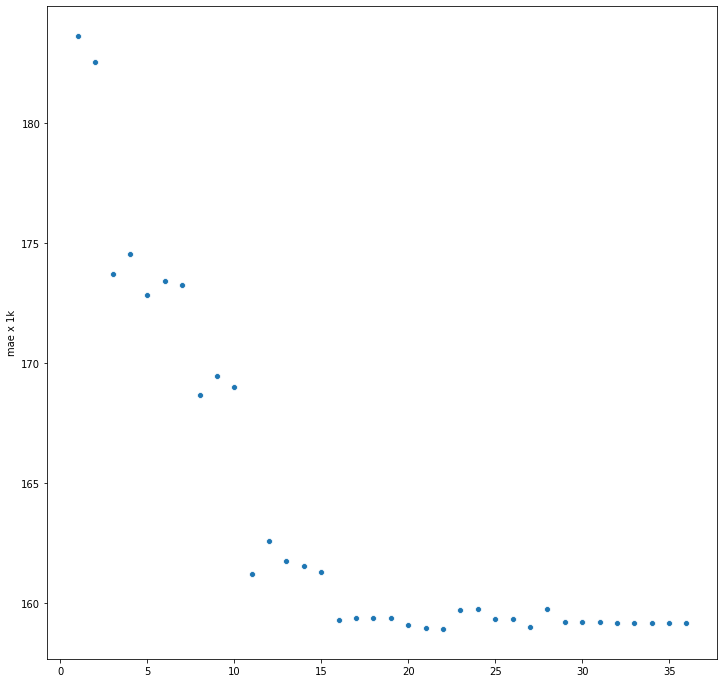

In [81]:
# Graphing MAE vs number of features

%matplotlib inline 
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))


sns.scatterplot(range(1,X_train_eng.shape[1]+1),mae_df['mae x 1k'])

fig.show()



---


###Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)

In [0]:
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

In [0]:
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(alphas=alphas, normalize=True)

Ridge Regression with one feature

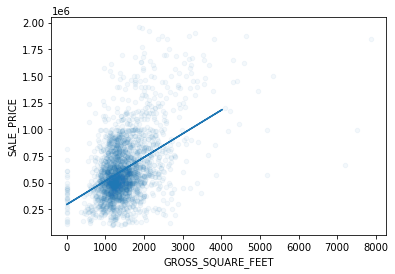

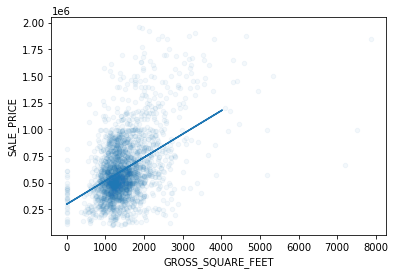

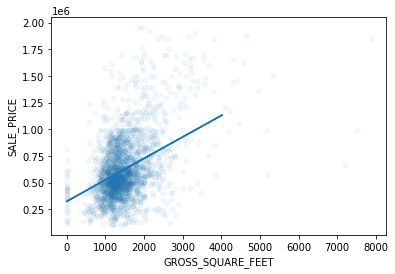

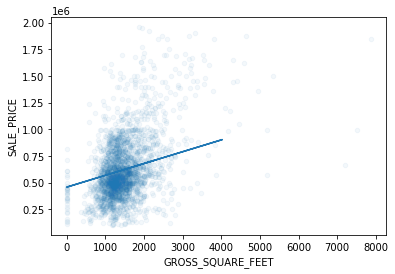

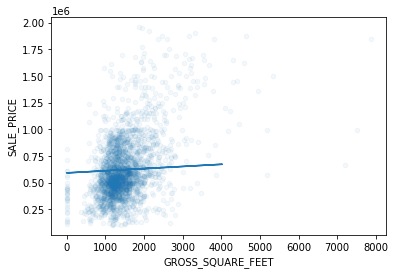

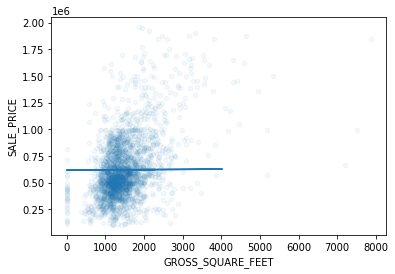

In [82]:
for alpha in [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]:
    
    # Fit Ridge Regression model
    feature = 'GROSS_SQUARE_FEET'
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train_eng[[feature]], y_train)
    
   
    # Get Test MAE
    y_pred = model.predict(X_test_eng[[feature]])
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    
    train.plot.scatter(feature, target, alpha=0.05)
    plt.plot(X_test_eng[feature], y_pred)
    plt.show()

Ridge Regression with multiple features

In [78]:
for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train_eng, y_train)
    y_pred = model.predict(X_test_eng)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    #coefficients = pd.Series(model.coef_, X_train.columns)
    #plt.figure(figsize=(16,8))
    #coefficients.sort_values().plot.barh(color='grey')
    #plt.xlim(-400,700)
    #plt.show()